<h1 style="text-align:center">
Processing CT Scans
<h1>

In [1]:
import pylidc as pl
from pylidc.utils import consensus
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from utils import get_nodule_class, filename_from_annotation, cluster_annots
import pandas as pd

In [2]:
from PIL import Image
from gtts import gTTS
from pytesseract import image_to_string
from scipy.io.wavfile import write

from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import spectrogram

import pandas as pd
from collections import Counter
import bisect

import librosa
import librosa.display

import soundfile as sf
import io


In [3]:
MAX_NODULE_WIDTH = 47
MAX_NODULE_HEIGHT = 47
N_SLICES = 5

---
Get Masks and Cropped Images


### Normalization

Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used thresholds are -1000 and 400.

**Warning**: Do not zero center with the mean per image. The CT scanners are calibrated to return accurate HU measurements.

In [4]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
    
def normalize(image):
    # Scale
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.

    # Zero mean
    image = image - PIXEL_MEAN

    return image

In [5]:
def zoomout_nodule(bbox, width, height, n_slices):
    # TODO: what if is outside the picture?
    x_acres = (width - (bbox[0].stop - bbox[0].start))//2
    y_acres = (height - (bbox[1].stop - bbox[1].start))//2

    x_slice = slice(bbox[0].start - x_acres, bbox[0].start - x_acres + width, None)
    y_slice = slice(bbox[1].start - y_acres, bbox[1].start - y_acres + height, None)

    z_slice = np.linspace(bbox[2].start, bbox[2].stop, n_slices, endpoint=False, dtype=int)

    return (x_slice, y_slice, z_slice)

(slice(343, 390, None), slice(296, 343, None), array([86, 87, 89, 91, 93]))


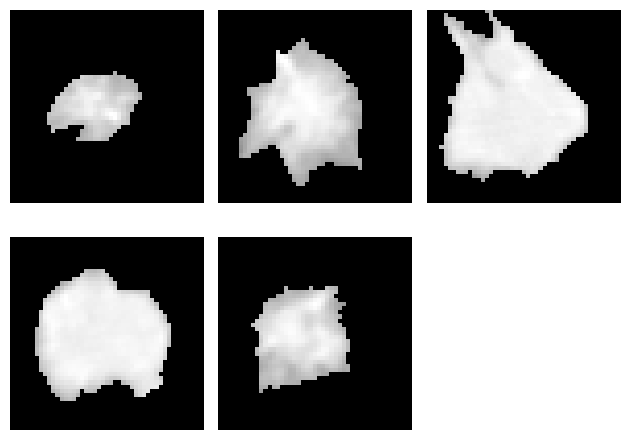

In [6]:
def get_cropped_annot(scan: pl.Scan, nods, mask: bool=False):
    if len(scan.annotations) == 0:
        return None

    vol = scan.to_volume(verbose=False)

    # Normalize values
    vol = normalize(vol)

    images = []
    masks = []
    for anns in nods:
        cmask, cbbox, _ = consensus(anns, clevel=0.5,
                                pad=[(10,10), (10,10), (0,0)])

        full_mask = np.full_like(vol, False, dtype=bool)
        full_mask[cbbox] = cmask

        cbbox = zoomout_nodule(cbbox, MAX_NODULE_WIDTH, MAX_NODULE_HEIGHT, N_SLICES)
        if cbbox[1].start < 0:
            cbbox = (cbbox[0], slice(0, 47, None), cbbox[2])
        print(cbbox)
        cropped = vol[cbbox]
        cropped_mask = ~full_mask[cbbox]
        if mask:
            cropped[cropped_mask] = -1

        images.append(cropped)
        masks.append(cropped_mask)

    return images, masks


scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
nods = cluster_annots(scan)
cropped, _ = get_cropped_annot(scan, nods, True)

# Set up the plot.
for i in range(N_SLICES):
    plt.subplot(2, 3, i+1)
    plt.imshow(cropped[0][:, :, i], cmap=plt.cm.gray)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
df_annotations = pd.read_csv('annotations_ds.csv')
df_annotations

,Unnamed: 0,ID,Scan_ID,Patient_ID,Texture,Spiculation,Lobulation,Margin,Sphericity,Calcification,Internal Structure,Subtlety,Malignancy
0,0,2,1,LIDC-IDRI-0078,5,2,2,3,4,6,1,4,4
1,1,1,1,LIDC-IDRI-0078,4,2,3,3,4,6,1,5,4
2,2,8,1,LIDC-IDRI-0078,5,1,1,5,5,5,1,4,1
3,3,3,1,LIDC-IDRI-0078,5,3,3,3,4,5,1,5,4
4,4,16,2,LIDC-IDRI-0069,5,4,4,4,4,6,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,2656,6850,1016,LIDC-IDRI-0639,3,3,2,2,4,6,1,4,4
2657,2657,6851,1016,LIDC-IDRI-0639,1,2,1,2,4,6,1,2,4
2658,2658,6856,1017,LIDC-IDRI-0638,5,1,2,4,4,6,1,3,4
2659,2659,6855,1017,LIDC-IDRI-0638,5,1,1,5,4,6,1,5,2


In [18]:
# TEMP: jupyter morreu

done_p = []
done_a = []
for _, _, files in os.walk("nn_data"):
    for f in files:
        if "mask" in f: continue
        done_p.append(int(f.split("-")[-2]))
        done_a.append(int(f.split("-")[-1][:-4]))

print(done_p, done_a)
print(len(done_a))

[68, 51, 18, 12, 312, 387, 773, 355, 507, 734, 464, 54, 892, 11, 922, 385, 912, 965, 386, 190, 628, 497, 312, 217, 982, 583, 366, 116, 819, 296, 394, 249, 893, 796, 362, 476, 799, 1007, 195, 148, 195, 93, 415, 285, 912, 134, 16, 78, 942, 790, 305, 595, 919, 686, 861, 195, 936, 60, 785, 770, 250, 893, 334, 507, 368, 67, 315, 229, 377, 59, 762, 260, 873, 81, 13, 834, 587, 305, 148, 610, 309, 153, 454, 55, 267, 601, 576, 250, 608, 252, 78, 556, 966, 260, 221, 920, 606, 708, 749, 60, 313, 628, 332, 703, 229, 137, 145, 29, 483, 404, 617, 171, 365, 72, 829, 179, 552, 217, 223, 66, 884, 260, 3, 332, 650, 686, 305, 15, 240, 981, 565, 244, 869, 415, 423, 60, 176, 229, 45, 259, 489, 597, 896, 132, 997, 844, 788, 543, 3, 1011, 52, 16, 41, 790, 775, 770, 498, 61, 661, 80, 978, 95, 49, 63, 404, 670, 720, 709, 242, 713, 730, 905, 740, 751, 394, 57, 163, 87, 793, 266, 89, 942, 680, 130, 698, 458, 294, 715, 820, 132, 188, 910, 60, 45, 112, 756, 508, 865, 701, 164, 493, 912, 186, 48, 557, 888, 702, 725

In [29]:
malign_path = Path("nn_data/images/malign")
belign_path = Path("nn_data/images/belign")
undetermined_path = Path("nn_data/images/undetermined")

os.makedirs(malign_path, exist_ok=True)
os.makedirs(belign_path, exist_ok=True)
os.makedirs(undetermined_path, exist_ok=True)

scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0487').all()
for scan in scans:
    try:
        # TEMP: jupyter morreu
        #if int(scan.patient_id.split("-")[-1]) in done_p:
            # print("skip", scan.patient_id)
        #    continue

        if len(scan.annotations) == 0:
            # Scan has no annotations, there is nothing to do
            continue

        print(scan.patient_id)

        nods = cluster_annots(scan)
        cropped, masks = get_cropped_annot(scan, nods, True)

        for i, anns in enumerate(nods):
            # TEMP: jupyter morreu
            if int(anns[0].id) in done_a:
                # print("skip", scan.patient_id, anns[0].id)
                # continue
                pass

            print(anns[0].id)
            print(cropped[i].shape)

            label = get_nodule_class(anns)
            #if label == 0:
                #continue
            
            filename = filename_from_annotation(anns[0])
            mask_filename = filename + "-mask"
            if label == 1:
                np.save(malign_path/filename, cropped[i].astype(np.float32))
                np.save(malign_path/mask_filename, masks[i].astype(np.float32))
            elif label == -1:
                np.save(belign_path/filename, cropped[i].astype(np.float32))
                np.save(belign_path/mask_filename, masks[i].astype(np.float32))
            else:
                np.save(undetermined_path/filename, cropped[i].astype(np.float32))
                np.save(undetermined_path/mask_filename, masks[i].astype(np.float32))

            # função do audio features dadas [id_paciente, id_anotação, ..info_som_..]
            #l = [scan.patient_id(), nods[i][0].id]+ sound_def(cropped[i][:,:,2])    
            #sound_def encontra-se em baixo 
    except RuntimeError as e:
        print(e)

LIDC-IDRI-0487
(slice(206, 253, None), slice(0, 47, None), array([44, 47, 50, 54, 57]))
(slice(64, 111, None), slice(384, 431, None), array([129, 130, 131, 132, 133]))
(slice(145, 192, None), slice(20, 67, None), array([133, 133, 134, 134, 135]))
(slice(78, 125, None), slice(142, 189, None), array([171, 171, 172, 172, 173]))
(slice(407, 454, None), slice(311, 358, None), array([176, 176, 177, 178, 179]))
(slice(123, 170, None), slice(100, 147, None), array([198, 199, 200, 201, 202]))
(slice(355, 402, None), slice(83, 130, None), array([313, 314, 315, 317, 318]))
(slice(340, 387, None), slice(68, 115, None), array([315, 315, 316, 317, 318]))
(slice(362, 409, None), slice(157, 204, None), array([334, 335, 336, 338, 339]))
3565
(47, 47, 5)
3576
(47, 47, 5)
3567
(47, 47, 5)
3574
(47, 47, 5)
3577
(47, 47, 5)
3564
(47, 47, 5)
3572
(47, 47, 5)
3571
(47, 47, 5)
3570
(47, 47, 5)


---

justificação da utilização de som(experiência)
->forma como img são vistas por computadores/diviação, pequenas distorções afetam bastante
->usar forma diff de ver img e ver se outros parâmetros naõ vistos diretamente atravás da img
->poss de usar nn para trabalhos foturos 
->retirar as features mais genéricamente usadas em imgs

justificação da utilização de cada parâmetro

max-min = 0.4325
% mais recorrente = 1.95
26.62 73.38


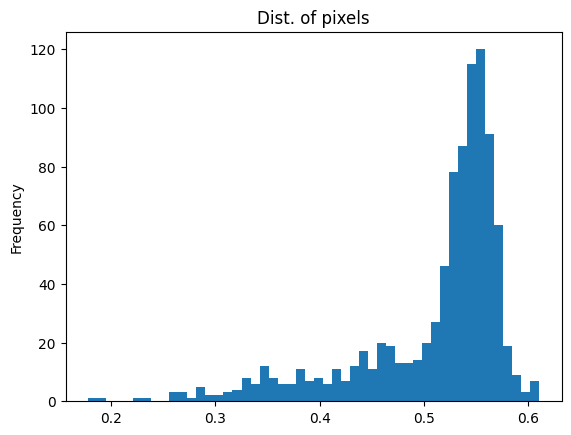

_________________


' \nintencidade                                               -> ver diff entre max e min\nfrequência                                                -> ver % do mais recorrente\nespectograma(variação das frequências)                    -> ver % de casos (entre 0.5 e 0.6) ou (aparência sup a 4%) \ntempo do audio                                            -> diff entre a maior frequência e a menor (max-min)\nfrequência fundamental                                    -> o mais frequênte abaixo de 0.5\ntaxa de cruzamento por zero                               ->\nenergia                                                   ->\n'

In [59]:
#import base64 

image_data = cropped[0][:,:,2] 

x1, y1 = image_data.shape

x = x1//2
y = y1//2

'''
#print(x, y)
#print(image_data[x][y]) #image is array
#print(image_data.max()) #pixel com mais intencidade
#print(image_data.min()) #pixel com menor intencidade

pd.Series(image_data.flatten()).plot(kind='hist',
                                       bins = 50,
                                       title='Dist. of pixels')
plt.show()

list = []
for i in range(x1):
    for j in range(y1):
        if image_data[i][j]!=0:
            list.append(image_data[i][j])


'''


def find_first_greater(list, x, comp):
    # Use bisect_right to find the index where x would go to maintain sorted order
    index = bisect.bisect_right(list, x)
    
    # Check if the index is within the bounds of the list
    if index < comp: #len(list)
        return index  # This is the first instance where the number is greater than x
    else:
        return comp+1  # If no element is greater than x

def racist(img):
    x1, y1 = img.shape
    x = x1//2
    y = y1//2
    list = []
    #print(f"comp = {len(list)}")
    for i in range(x1):
        for j in range(y1):
            if image_data[i][j]!=0:
                list.append(float(image_data[i][j]))
    comp = len(list)

    #print(f"comp = {comp}")
    list = sorted(list)#, key=float

    #ver max diff
    print(f"max-min = {round(list[comp-1] - list[0],4)}")

    ''' 
    tentar div list em 50 diff catg
    '''

    counter = Counter(list)

    #ver % do mais recorrente
    print(f"% mais recorrente = {round(counter.most_common(1)[0][1]*100/comp,2)}")
     
    cinf = round((find_first_greater(list, 0.5, comp)-1)*100/comp,2)
    csup = round(100-cinf,2)
    print(cinf, csup)

    #most common zone
    #mcommon = round(bindario(list),2)
    #print(f"most common zone -> {mcommon}")

    return list


list = racist(image_data)
#print(list)

#for pixel-if != 0 -> traduzir para frequência


#print(type(list), type(image_data), type(image_data[0][0]), type(float(image_data[0][0])), type(list[0]))

pd.Series(list).plot(kind='hist',
                                       bins = 50,
                                       title='Dist. of pixels')
plt.show()


print('_________________')


# Your list of numbers (replace this with your actual data)
#numbers = [...]  # Replace this with your list

# Define the number of bins (50 bins)


def bindario(list):
    num_bins = 50

    bin_edges = np.linspace(min(list), max(list), num_bins + 1)

    binned_indices = np.digitize(list, bin_edges) - 1  #  Subtract 1 to make bins zero-based
    binned_indices = binned_indices[:-1]

    bins = [0 for _ in range(num_bins)]
    for num, bin_idx in zip(list, binned_indices):
        bins[bin_idx]+=1

    #print(type(bin_edges))
    #print(bin_edges)

    #find pos of max
    #print((bin_edges[bins.index(max(bins))] + bin_edges[bins.index(max(bins))+1])/2)

    return(bin_edges[bins.index(max(bins))] + bin_edges[bins.index(max(bins)) + 1])/2




#image_data = image_data.copy(order='C')

#converted_string = base64.b64encode(image_data) 
#print(converted_string)
 
  
#sound = gTTS(converted_string, lang="en")
#sound.save("sound.mp3")

''' 
intencidade                                               -> ver diff entre max e min
frequência                                                -> ver % do mais recorrente
espectograma(variação das frequências)                    -> ver % de casos (entre 0.5 e 0.6) ou (aparência sup a 4%) 
tempo do audio                                            -> diff entre a maior frequência e a menor (max-min)
frequência fundamental                                    -> o mais frequênte abaixo de 0.5
taxa de cruzamento por zero                               ->
energia                                                   ->
'''


In [7]:
''' 
por imagem
converter em som
'''

#image_data = cropped[0][:,:,0]  
image_data = cropped[0]


def convert_to_sound(image_data):
    
    min_freq = 20      # Minimum frequency (Hz)
    max_freq = 20000   # Maximum frequency (Hz)

    # Generate a sine wave for each pixel
    sample_rate = 44100  # Standard sampling rate for audio (Hz)
    duration = 0.01      # Duration of each pixel's sound (seconds)

    #img = Image.fromarray(image_data).convert('L')
    #img_data = np.array(image_data)

    ''''''


    img_data = image_data[:,:,0]
    img_data = img_data[img_data > 0]
    img_data = np.array(img_data)
    for i in range(1, N_SLICES):
        i_dat = image_data[:,:,i]
        i_dat = i_dat[i_dat>0]
        if i == 2:
            ii_data = np.array(i_dat)
        img_data = np.append(img_data, np.array(i_dat))

    


    # Normalize the pixel intensities to the frequency range
    frequencies = np.interp(img_data, [0, 0.7], [min_freq, max_freq])  #[0, 255] 
    iifrequencies = np.interp(ii_data, [0, 0.7], [min_freq, max_freq])  #[0, 255] 


    audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])

    audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

    
    iiaudio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in iifrequencies.flatten()])

    iiaudio_data = np.int16(iiaudio_data / np.max(np.abs(iiaudio_data)) * 32767)

    return audio_data, sample_rate, iiaudio_data


''' 
# Convert NumPy array to a Pillow Image
img = Image.fromarray(image_data).convert('L')

img_data = np.array(img)

# Normalize pixel values to a frequency range (e.g., 20 Hz to 20,000 Hz)
min_freq = 20      # Minimum frequency (Hz)
max_freq = 20000   # Maximum frequency (Hz)

# Normalize the pixel intensities to the frequency range
frequencies = np.interp(img_data, [0, 255], [min_freq, max_freq])

# Generate a sine wave for each pixel
sample_rate = 44100  # Standard sampling rate for audio (Hz)
duration = 0.01      # Duration of each pixel's sound (seconds)

# Create an audio array by stacking sine waves
audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])

# Normalize the audio data
audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

x1, y1 = image_data.shape
    x = x1//2
    y = y1//2
    print(image_data[x][y])
    print(img_data[x][y])


# Save the result as a WAV file
#write("image_to_sound.wav", sample_rate, audio_data)
'''



def generate_sine_wave(frequency, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    return wave


ad, sr, iiad = convert_to_sound(image_data)


# imagem das 5 camadas do nódulo do paciente 0001

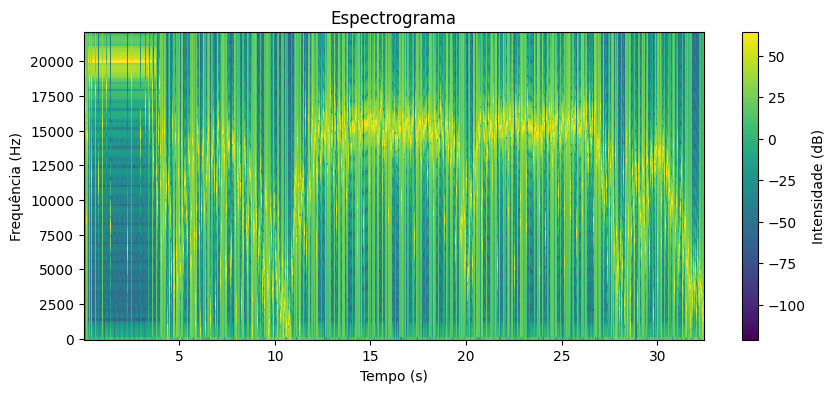

In [24]:
''' 
intencidade
frequência 
espectograma(variação das frequências)
tempo do audio
frequência fundamental
taxa de cruzamento por zero
energia
'''


#criar lista com as infos [duration, frequência fundamental, taxa de cruzamento por zero, energia]

duration = len(ad) / sr


# Análise 3: Espectrograma (Domínio da Frequência ao Longo do Tempo)
frequencies, times, Sxx = spectrogram(ad, sr)
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma')
plt.colorbar(label='Intensidade (dB)')
plt.show()

# imagem da 1ª camada do nódulo do paciente 0001

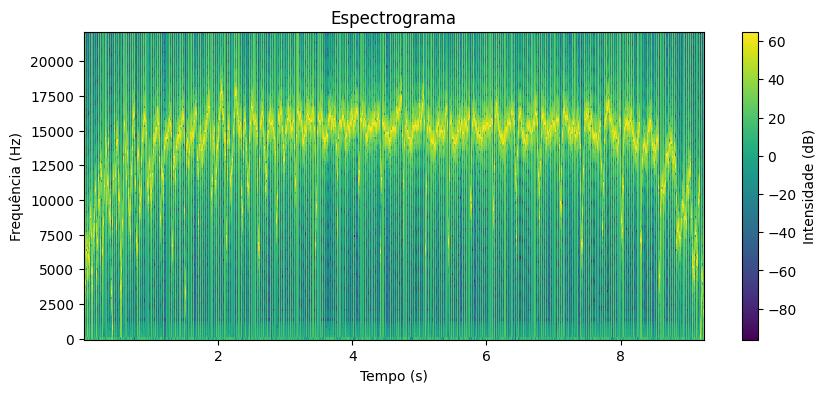

In [28]:
frequencies, times, Sxx = spectrogram(iiad, sr)
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma')
plt.colorbar(label='Intensidade (dB)')
plt.show()

neste caso(e possívelmente em futuros) a 1ª camada distoa bastante do resto,
possiveis razões: desconhecido até ao momento
possíveis problemas: dados obtidos podem ser drásticamente e incorretamente alterados por isto(mera espéculação)

ideia, primeiramente obtenção de dados para apenas a camada central, numa segunda parte usar as camadas todas

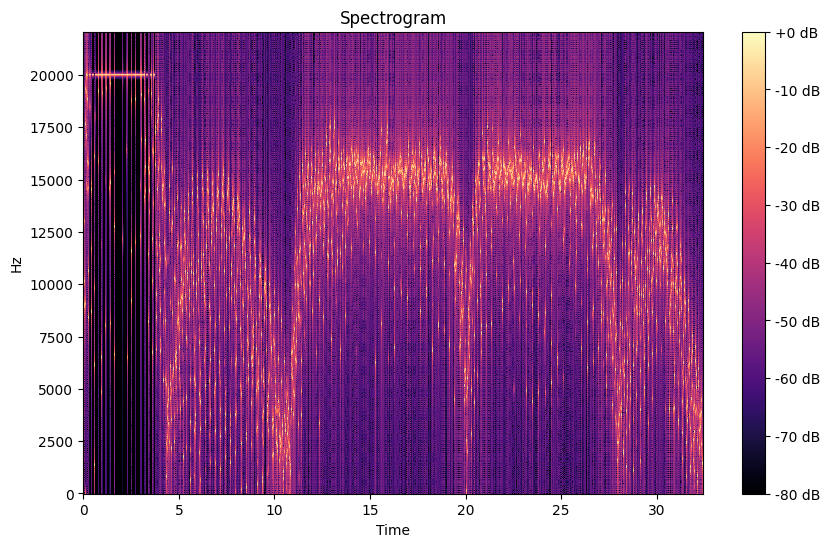

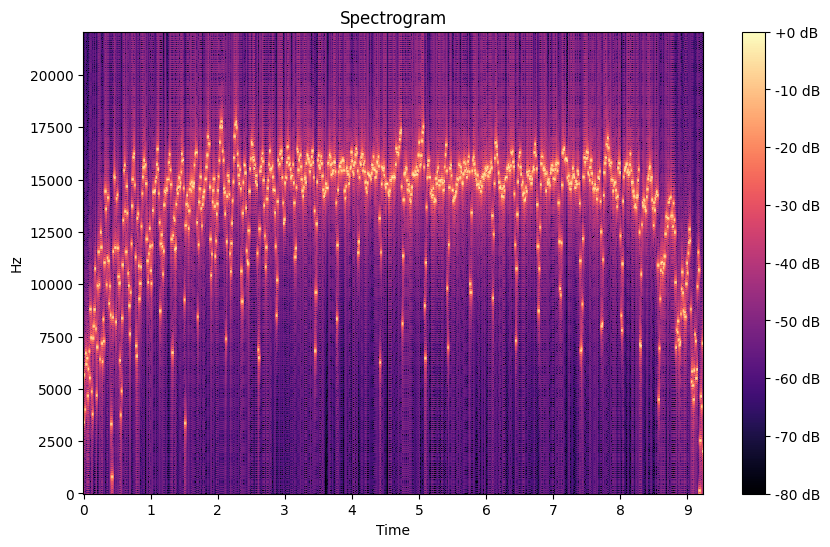

In [29]:

def ver_specto(audio_data, sample_rate):
    # Check if the audio data is integer type
    if np.issubdtype(audio_data.dtype, np.integer):
        # Normalize the audio data to float32 in the range [-1, 1]
        audio_data = audio_data / np.max(np.abs(audio_data), axis=0)

    S = librosa.stft(audio_data)  # Short-time Fourier transform
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)  # Convert to decibel scale

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()
    return

ver_specto(ad, sr)
ver_specto(iiad, sr)


RNN to complicated for this progect so, we are merly using some commonly used features

# choosing features for extraction

- **ZCR:** is the rate of sign-changes along a signal(how many times the waveform crosses the zero axis within a specified time frame) this feature is used to classify percussive sounds and could also serve to detect anomalies in time-series data. It gives a representation of the smoothness of the wave

- **frequência fundamental:** fundamental frequency of a signal is the greatest common divisor (GCD) of all the frequency components contained in a signal/or/ is the lowest frequency at which a system oscillates. It can aid in identifying and classifying patterns

- **spectral centroid:** considered the center of 'gravity' of the spectrum(center of amplitude-weighted frequency distribution), it measures the spectral shape and position of the spectrum. If the spectral centroid is high, the sound is perceived as "brighter" or "sharper"

- **spectral bandwidth:** describes the width or spread of frequencies around the spectral centroid(how "wide" vs "narrow" the frequency distribution is)

- **onset times:**  refer to the moments in a sound signal where a new sound begins, or more formally, where the amplitude of the sound suddenly increases. onset_times array contains the timestamps at which new sounds begin in an audio signal

- **tempo:** annother name for speed, mesured by beats per minute(BPM) 
 
- **dynamic range:** is, in this case, a base-10 logarithmic value of the difference between the largest and the smallest values 

- intencidade/amplitude média, máxima e minima
- energia total





fontes
ZCR: https://www.sciencedirect.com/topics/engineering/zero-crossing-rate, https://en.wikipedia.org/wiki/Zero-crossing_rate, https://statisticseasily.com/glossario/what-is-zero-crossing-rate/

FF: https://academia-lab.com/enciclopédia/frequencia-fundamental/, https://web.archive.org/web/20140514122624/http://fourier.eng.hmc.edu/e101/lectures/Fundamental_Frequency.pdf, https://chatgpt.com/

SC: https://www.sciencedirect.com/topics/engineering/spectral-centroid

SB: https://www.sciencedirect.com/topics/engineering/spectral-bandwidth, http://acousticslab.org/RECA220/PMFiles/Module06.htm#timbreb

TEMPO: https://theonlinemetronome.com/blogs/12/tempo-markings-defined

OT: chat gpt

DR: https://en.wikipedia.org/wiki/Dynamic_range



In [14]:
#ZCR
def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

zcr = zero_crossing_rate(ad)
iizcr = zero_crossing_rate(iiad)

print(f'Zero Crossing Rate: {zcr:.2f}')
print(f'ii ->Zero Crossing Rate: {iizcr}')



# Energia
energia_total = np.sum(ad ** 2)

ienergia_total = np.sum(iiad ** 2)

print(f"energia total = {energia_total}")
print(f"ii ->energia total = {ienergia_total}")



def frequencia_fundamental(audio_data):
    # Ensure the audio data is in floating-point format
    if audio_data.dtype != np.float32 and audio_data.dtype != np.float64:
        audio_data = audio_data.astype(np.float32) / np.max(np.abs(audio_data))  # Normalize to [-1.0, 1.0]

    # Compute the fundamental frequency (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(audio_data, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))

    # Filter out NaN values from the fundamental frequency
    f0_filtered = f0[~np.isnan(f0)]
    
    if len(f0_filtered) > 0:
        ff = np.mean(f0_filtered)  # Mean of the fundamental frequencies
    else:
        ff = 0  # If no valid frequencies, return 0
    
    return ff

'''
ff = round(frequencia_fundamental(ad),2)
print(f'Frequência Fundamental: {ff} Hz')

iff = round(frequencia_fundamental(iiad),2)
print(f'ii ->Frequência Fundamental: {iff} Hz')
'''




def extract_spectral_features(audio_data, sample_rate):
    # Ensure the audio data is in floating-point format
    if audio_data.dtype != np.float32 and audio_data.dtype != np.float64:
        audio_data = audio_data.astype(np.float32) / np.max(np.abs(audio_data))  # Normalize to [-1.0, 1.0]

    # Calculate the spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
    # Calculate the spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate)

    # Return the mean values for a single representative figure (you can also return the full arrays if preferred)
    centroid_mean = np.mean(spectral_centroid)
    bandwidth_mean = np.mean(spectral_bandwidth)

    return centroid_mean, bandwidth_mean

cm, bm = extract_spectral_features(ad, sr)
print(f'CM: {cm} and BM: {bm}')

icm, ibm = extract_spectral_features(iiad, sr)
print(f'ii ->CM: {icm} and BM: {ibm}')



def extract_rhythm_features(audio_data, sample_rate):
    # Ensure the audio data is in floating-point format
    if audio_data.dtype != np.float32 and audio_data.dtype != np.float64:
        audio_data = audio_data.astype(np.float32) / np.max(np.abs(audio_data))  # Normalize to [-1.0, 1.0]

    # Calculate the tempo and beat frames
    tempo, beat_frames = librosa.beat.beat_track(y=audio_data, sr=sample_rate)
    # Convert beat frames to timestamps
    #no need
    #beat_times = librosa.frames_to_time(beat_frames, sr=sample_rate)

    # Detect onsets
    onset_frames = librosa.onset.onset_detect(y=audio_data, sr=sample_rate)
    onset_times = librosa.frames_to_time(onset_frames, sr=sample_rate)
    num_onset = len(onset_times)

    # Inter-Onset Intervals(IOIs)
    # array of intervals between onsets
    iois = np.diff(onset_times)
    mean_ioi = np.mean(iois)
    variance_ioi = np.var(iois)

    onset_density = num_onset / (onset_times[-1] - onset_times[0])  # Onsets per second


    return tempo[0], num_onset, mean_ioi, variance_ioi, onset_density

t, no, mioi, vioi, od = extract_rhythm_features(ad, sr)
print(f't: {t}, no: {no}, mioi: {mioi}, vioi: {vioi}, od: {od}')

it, ino, imioi, ivioi, iod = extract_rhythm_features(iiad, sr)
print(f'ii ->t: {it}')



def calculate_dynamic_range(audio_data):
    # Ensure audio_data is a numpy array for efficient processing
    audio_data = np.array(audio_data)

    # Calculate the maximum and minimum values of the absolute amplitudes
    max_amplitude = np.max(np.abs(audio_data))
    min_amplitude = np.min(np.abs(audio_data[np.nonzero(audio_data)]))  # Avoid zero values

    #print(max_amplitude, min_amplitude)
    # Convert amplitudes to decibel (dB) scale
    max_db = 20 * np.log10(max_amplitude)
    min_db = 20 * np.log10(min_amplitude)

    # Dynamic range is the difference between max and min in dB
    
    dynamic_range = max_db - min_db

    return dynamic_range, max_amplitude, min_amplitude, np.mean(np.abs(audio_data))

print(f'dynamic range: {calculate_dynamic_range(ad)}')
print(f'ii ->dynamic range: {calculate_dynamic_range(iiad)}')

''' 
notas 
->descobrir o q intencidade 
->ver relevância de duração
->normalizar energia total e frequência fundamental
Gradient/movement (smooth vs. sharp transitions)
'''

Zero Crossing Rate: 0.50
ii ->Zero Crossing Rate: 0.4974428443816199
int mean: 20825.02984716314
ii ->int mean: 20827.94768383544
energia total = 210594685
ii ->energia total = 80187448
CM: 10970.47392884709 and BM: 3036.948160502057
ii ->CM: 13408.44393004739 and BM: 2972.393794485227
t: 112.34714673913044, no: 371, mioi: 0.08170913770913771, vioi: 0.002045724522981578, od: 12.271610383064518
ii ->t: 112.34714673913044
dynamic range: (90.3087329864502, 32767, 1, 20825.02984716314)
ii ->dynamic range: (90.3087329864502, 32767, 1, 20827.94768383544)


' \nnotas \n->descobrir o q intencidade \n->ver relevância de duração\n->normalizar energia total e frequência fundamental\nGradient/movement (smooth vs. sharp transitions)\n'

In [20]:
''' 
função para extrair cenas do som
return lista 
'''

def sound_def(image_data):
    ad, sr, iiad = convert_to_sound(image_data)

    #no fim sum the lists
    #[ZCR, energia total, dynamic_range, max_amp, min_amp, mean_amp]
    list = [((ad[:-1] * ad[1:]) < 0).sum() / len(ad), np.sum(ad ** 2)]
    ilist = [((iiad[:-1] * iiad[1:]) < 0).sum() / len(iiad), np.sum(iiad ** 2)]

    for i in calculate_dynamic_range(ad):
        list.append(i)

    for i in calculate_dynamic_range(iiad):
        ilist.append(i)

    # Ensure the audio data is in floating-point format
    if ad.dtype != np.float32 and ad.dtype != np.float64:
        ad = ad.astype(np.float32) / np.max(np.abs(ad))  # Normalize to [-1.0, 1.0]

    if iiad.dtype != np.float32 and iiad.dtype != np.float64:
        iiad = iiad.astype(np.float32) / np.max(np.abs(iiad))  


    #FF
    for i in calculate_ff_sf_rf(ad, sr):
        list.append(i)

    for i in calculate_ff_sf_rf(iiad, sr):
        ilist.append(i)


    #[ZCR, energia total, dynamic_range, max_amp, min_amp, mean_amp, ff, centroid_mean, bandwidth_mean, tempo, num_onset, mean_ioi, variance_ioi, onset_density]
    
    l = [*list,*ilist]

    return l




def convert_to_sound(image_data):
    
    min_freq = 20      # Minimum frequency (Hz)
    max_freq = 20000   # Maximum frequency (Hz)

    # Generate a sine wave for each pixel
    sample_rate = 44100  # Standard sampling rate for audio (Hz)
    duration = 0.01      # Duration of each pixel's sound (seconds)

    
    # Aglumerating all layers of the scann
    img_data = image_data[:,:,0]
    img_data = img_data[img_data > 0]
    img_data = np.array(img_data)
    for i in range(1, N_SLICES):
        i_dat = image_data[:,:,i]
        i_dat = i_dat[i_dat>0]
        if i == 2:
            ii_data = np.array(i_dat)
        img_data = np.append(img_data, np.array(i_dat))

    

    # Normalize the pixel intensities to the frequency range
    frequencies = np.interp(img_data, [0, 0.7], [min_freq, max_freq])  #[0, 255]  
    iifrequencies = np.interp(ii_data, [0, 0.7], [min_freq, max_freq])  #[0, 255] 

    audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])
    audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

    iiaudio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in iifrequencies.flatten()])
    iiaudio_data = np.int16(iiaudio_data / np.max(np.abs(iiaudio_data)) * 32767)

    return audio_data, sample_rate, iiaudio_data





def generate_sine_wave(frequency, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    return wave


######################

def calculate_dynamic_range(audio_data):
    # Ensure audio_data is a numpy array for efficient processing
    audio_data = np.array(audio_data)

    # Calculate the maximum and minimum values of the absolute amplitudes
    max_amplitude = np.max(np.abs(audio_data))
    min_amplitude = np.min(np.abs(audio_data[np.nonzero(audio_data)]))  # Avoid zero values

    #print(max_amplitude, min_amplitude)
    # Convert amplitudes to decibel (dB) scale
    max_db = 20 * np.log10(max_amplitude)
    min_db = 20 * np.log10(min_amplitude)

    # Dynamic range is the difference between max and min in dB
    
    dynamic_range = max_db - min_db

    return dynamic_range, max_amplitude, min_amplitude, np.mean(np.abs(audio_data))





def calculate_ff_sf_rf(audio_data, sample_rate):

    ## Compute the fundamental frequency (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(audio_data, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))

    # Filter out NaN values from the fundamental frequency
    f0_filtered = f0[~np.isnan(f0)]
    
    if len(f0_filtered) > 0:
        ff = np.mean(f0_filtered)  # Mean of the fundamental frequencies
    else:
        ff = 0  # If no valid frequencies, return 0




    ## Calculate spectral features
    # Calculate the spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
    # Calculate the spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate)

    # Return the mean values for a single representative figure (you can also return the full arrays if preferred)
    centroid_mean = np.mean(spectral_centroid)
    bandwidth_mean = np.mean(spectral_bandwidth)



    ## Rhythm features
    tempo, beat_frames = librosa.beat.beat_track(y=audio_data, sr=sample_rate)

    # Detect onsets
    onset_frames = librosa.onset.onset_detect(y=audio_data, sr=sample_rate)
    onset_times = librosa.frames_to_time(onset_frames, sr=sample_rate)
    num_onset = len(onset_times)

    # Inter-Onset Intervals(IOIs)
    # array of intervals between onsets
    iois = np.diff(onset_times)
    mean_ioi = np.mean(iois)
    variance_ioi = np.var(iois)

    onset_density = num_onset / (onset_times[-1] - onset_times[0])  # Onsets per second

    
    return round(ff,2), centroid_mean, bandwidth_mean, tempo[0], num_onset, mean_ioi, variance_ioi, onset_density







image_data = cropped[0] 
list = sound_def(image_data)
for i in list:
    print(i)


0.49745421475538326
210594685
90.3087329864502
32767
1
20825.02984716314
2967.81
10970.47392884709
3036.948160502057
112.34714673913044
371
0.08170913770913771
0.002045724522981578
12.271610383064518
0.4974428443816199
80187448
90.3087329864502
32767
1
20827.94768383544
3017.04
13408.44393004739
2972.393794485227
112.34714673913044
125
0.07387316216809303
0.001261681037233913
13.645882842205323


In [ ]:
'''
para cada imagem 
'''
import csv


scans = pl.query(pl.Scan)
data = []
for scan in scans:
    try:

        if len(scan.annotations) == 0:
            # Scan has no annotations, there is nothing to do
            continue

        print(scan.patient_id)

        nods = cluster_annots(scan)
        cropped, masks = get_cropped_annot(scan, nods, True)

        for i, anns in enumerate(nods):
            #result = sound_def(cropped[i][:,:,2])
            data.append(sound_def(cropped[i]))
        

    except RuntimeError as e:
        print(e)


# writing data to a CSV file
with open('sound_data.csv', 'w', newline='') as csvfile:

    csvwriter = csv.writer(csvfile)

    #[ZCR, intencidade média, intensidade máxima, energia total, frequência fundamental]
    csvwriter.writerow(['ZCR', 'intencidade média', 'intensidade máxima', 'energia total', 'frequência fundamental'])  # Customize as needed

    csvwriter.writerows(data)


    

#recives list off nodules
def get_sound(scans):

    data = []

    for scan in scans:
        # Call sound_def function for each image
        result = sound_def(scan[:,:,2]) #get only the half layer
        # Append result to data list. Optionally, include image name/path in each row
        data.append(result)


    # writing data to a CSV file
    with open('sound_data.csv', 'w', newline='') as csvfile:

        csvwriter = csv.writer(csvfile)

        #[ZCR, intencidade média, intensidade máxima, energia total, frequência fundamental]
        csvwriter.writerow(['ZCR', 'intencidade média', 'intensidade máxima', 'energia total', 'frequência fundamental'])  # Customize as needed

        csvwriter.writerows(data)